In [1]:
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import notebook, tqdm

In [2]:
class MyAE_512(nn.Module):
    def __init__(self):
        super(MyAE_512, self).__init__()

        self.encoder = nn.Linear(768, 512)
        self.decoder = nn.Linear(512, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x

    def encode(self, embed):
        output = self.encoder(embed)
        return output


class MyAE_256(nn.Module):
    def __init__(self):
        super(MyAE_256, self).__init__()

        self.encoder = nn.Linear(768, 256)
        self.decoder = nn.Linear(256, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x

    def encode(self, embed):
        output = self.encoder(embed)
        return output


class MyAE_128(nn.Module):
    def __init__(self):
        super(MyAE_128, self).__init__()

        self.encoder = nn.Linear(768, 128)
        self.decoder = nn.Linear(128, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x

    def encode(self, embed):
        output = self.encoder(embed)
        return output


class MyAE_64(nn.Module):
    def __init__(self):
        super(MyAE_64, self).__init__()

        self.encoder = nn.Linear(768, 64)
        self.decoder = nn.Linear(64, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x

    def encode(self, embed):
        output = self.encoder(embed)
        return output

In [3]:
def draw_history(history):
    plt.plot(history, label="train")
    plt.legend()
    plt.show()


def train(
    model, device, optimizer, criterion, epochs, train_loader) -> dict:
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param optimizer: your optimizer
    :param criterion: loss function
    :param epoch: train epochs
    :param train_loader: train dataset
    :param valid_loader: valid dataset
    :return: history dictionary that contains train_loss, train_acc, valid_loss, valid_acc as list
    """
    history = []
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        
        pbar = tqdm(enumerate(train_loader), file=sys.stdout)
        for batch_idx, data in pbar:
            data = data.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(epoch=f"{epoch}/{epochs}", loss="{:.6f}".format(loss))
        pbar.close()

        train_loss = train_loss / len(train_loader)
        history.append(train_loss)

    return history

In [4]:
class MyDataset(Dataset):
    def __init__(self, npy_path='../data/embed_768.npy'):
        super(MyDataset, self).__init__()

        self.data = np.load(npy_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        return x

In [5]:
myDataset = MyDataset('../data/embed_768.npy')
data_loader = DataLoader(myDataset, batch_size=64)

## 768 -> 512

In [8]:
model = MyAE_512().cuda()
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.MSELoss()

summary(model, input_size=(768,), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         393,728
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 768]         393,984
Total params: 787,712
Trainable params: 787,712
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.00
Estimated Total Size (MB): 3.02
----------------------------------------------------------------


In [9]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 20, data_loader)

============================= Train =============================
1985it [00:05, 380.63it/s, epoch=1/20, loss=0.012225]
1985it [00:05, 352.54it/s, epoch=2/20, loss=0.013503]
1985it [00:05, 346.90it/s, epoch=3/20, loss=0.012547]
1985it [00:05, 340.87it/s, epoch=4/20, loss=0.013631]
1985it [00:05, 356.94it/s, epoch=5/20, loss=0.013895]
1985it [00:05, 353.97it/s, epoch=6/20, loss=0.011991]
1985it [00:05, 354.33it/s, epoch=7/20, loss=0.012987]
1985it [00:05, 357.10it/s, epoch=8/20, loss=0.014219]
1985it [00:05, 358.59it/s, epoch=9/20, loss=0.013346]
1985it [00:05, 348.44it/s, epoch=10/20, loss=0.013139]
1985it [00:05, 346.04it/s, epoch=11/20, loss=0.013727]
1985it [00:05, 353.37it/s, epoch=12/20, loss=0.012408]
1985it [00:05, 355.50it/s, epoch=13/20, loss=0.012864]
1985it [00:05, 356.76it/s, epoch=14/20, loss=0.012738]
1985it [00:05, 357.00it/s, epoch=15/20, loss=0.013039]
1985it [00:05, 356.05it/s, epoch=16/20, loss=0.013416]
1985it [00:05, 350.74it/s, epoch=17/20, loss=0.012632]
1985it [

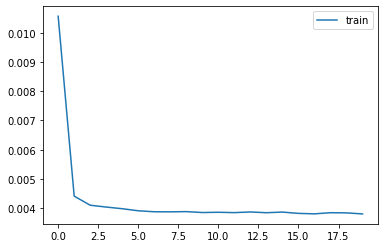

In [10]:
draw_history(history)

In [11]:
torch.save(model, 'AE512.pt')

In [12]:
embed = torch.FloatTensor(myDataset.data)
model.cpu()
with torch.no_grad():
    embed_512 = model.encode(embed)
    embed_512_np = embed_512.numpy()

print(embed_512.shape)
print(embed_512_np.shape)

np.save('../data/embed_512.npy', embed_512_np)

torch.Size([127036, 512])
(127036, 512)


## 768 -> 256

In [13]:
model = MyAE_256().cuda()
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.MSELoss()

summary(model, input_size=(768,), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         196,864
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 768]         197,376
Total params: 394,240
Trainable params: 394,240
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.50
Estimated Total Size (MB): 1.52
----------------------------------------------------------------


In [14]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 20, data_loader)

============================= Train =============================
1985it [00:05, 338.36it/s, epoch=1/20, loss=0.017932]
1985it [00:06, 319.10it/s, epoch=2/20, loss=0.018034]
1985it [00:05, 332.71it/s, epoch=3/20, loss=0.016974]
1985it [00:05, 350.77it/s, epoch=4/20, loss=0.016773]
1985it [00:05, 356.56it/s, epoch=5/20, loss=0.017871]
1985it [00:05, 361.71it/s, epoch=6/20, loss=0.017264]
1985it [00:05, 368.30it/s, epoch=7/20, loss=0.017094]
1985it [00:05, 365.79it/s, epoch=8/20, loss=0.017582]
1985it [00:05, 355.68it/s, epoch=9/20, loss=0.017769]
1985it [00:05, 355.59it/s, epoch=10/20, loss=0.018265]
1985it [00:05, 355.60it/s, epoch=11/20, loss=0.018271]
1985it [00:05, 356.58it/s, epoch=12/20, loss=0.018205]
1985it [00:05, 358.21it/s, epoch=13/20, loss=0.017879]
1985it [00:05, 355.24it/s, epoch=14/20, loss=0.017930]
1985it [00:05, 357.10it/s, epoch=15/20, loss=0.018491]
1985it [00:05, 359.98it/s, epoch=16/20, loss=0.017887]
1985it [00:05, 359.59it/s, epoch=17/20, loss=0.019075]
1985it [

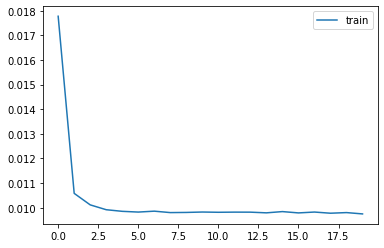

In [15]:
draw_history(history)

In [16]:
torch.save(model, 'AE256.pt')

In [17]:
embed = torch.FloatTensor(myDataset.data)
model.cpu()
with torch.no_grad():
    embed_256 = model.encode(embed)
    embed_256_np = embed_256.numpy()

print(embed_256.shape)
print(embed_256_np.shape)

np.save('../data/embed_256.npy', embed_256_np)

torch.Size([127036, 256])
(127036, 256)


## 768 -> 128

In [18]:
model = MyAE_128().cuda()
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.MSELoss()

summary(model, input_size=(768,), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          98,432
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 768]          99,072
Total params: 197,504
Trainable params: 197,504
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.75
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


In [19]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 20, data_loader)

============================= Train =============================
1985it [00:05, 383.43it/s, epoch=1/20, loss=0.033134]
1985it [00:05, 383.64it/s, epoch=2/20, loss=0.032380]
1985it [00:05, 364.24it/s, epoch=3/20, loss=0.032802]
1985it [00:05, 350.52it/s, epoch=4/20, loss=0.032663]
1985it [00:05, 375.72it/s, epoch=5/20, loss=0.031806]
1985it [00:05, 371.98it/s, epoch=6/20, loss=0.032695]
1985it [00:05, 370.02it/s, epoch=7/20, loss=0.032961]
1985it [00:05, 366.02it/s, epoch=8/20, loss=0.032199]
1985it [00:05, 349.66it/s, epoch=9/20, loss=0.032893]
1985it [00:05, 337.02it/s, epoch=10/20, loss=0.032418]
1985it [00:05, 360.75it/s, epoch=11/20, loss=0.033228]
1985it [00:05, 368.40it/s, epoch=12/20, loss=0.032632]
1985it [00:05, 364.00it/s, epoch=13/20, loss=0.032808]
1985it [00:05, 346.64it/s, epoch=14/20, loss=0.032392]
1985it [00:05, 348.07it/s, epoch=15/20, loss=0.032614]
1985it [00:05, 354.08it/s, epoch=16/20, loss=0.032119]
1985it [00:05, 350.80it/s, epoch=17/20, loss=0.033782]
1985it [

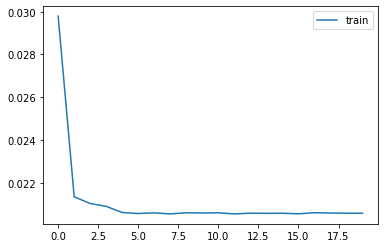

In [20]:
draw_history(history)

In [21]:
torch.save(model, 'AE128.pt')

In [22]:
embed = torch.FloatTensor(myDataset.data)
model.cpu()
with torch.no_grad():
    embed_128 = model.encode(embed)
    embed_128_np = embed_128.numpy()

print(embed_128.shape)
print(embed_128_np.shape)

np.save('../data/embed_128.npy', embed_128_np)

torch.Size([127036, 128])
(127036, 128)


## 768 -> 64

In [6]:
model = MyAE_64().cuda()
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.MSELoss()

summary(model, input_size=(768,), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          49,216
              ReLU-2                   [-1, 64]               0
            Linear-3                  [-1, 768]          49,920
Total params: 99,136
Trainable params: 99,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [7]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 20, data_loader)

============================= Train =============================
1985it [00:05, 363.10it/s, epoch=1/20, loss=0.047402]
1985it [00:06, 316.98it/s, epoch=2/20, loss=0.047289]
1985it [00:06, 312.34it/s, epoch=3/20, loss=0.046668]
1985it [00:05, 335.28it/s, epoch=4/20, loss=0.047111]
1985it [00:05, 333.40it/s, epoch=5/20, loss=0.047495]
1985it [00:05, 368.37it/s, epoch=6/20, loss=0.046556]
1985it [00:05, 344.92it/s, epoch=7/20, loss=0.047527]
1985it [00:05, 350.34it/s, epoch=8/20, loss=0.046969]
1985it [00:05, 340.19it/s, epoch=9/20, loss=0.046825]
1985it [00:05, 332.75it/s, epoch=10/20, loss=0.047873]
1985it [00:06, 327.96it/s, epoch=11/20, loss=0.047473]
1985it [00:06, 326.81it/s, epoch=12/20, loss=0.047647]
1985it [00:05, 338.95it/s, epoch=13/20, loss=0.047828]
1985it [00:05, 330.94it/s, epoch=14/20, loss=0.047459]
1985it [00:06, 329.13it/s, epoch=15/20, loss=0.048179]
1985it [00:06, 308.45it/s, epoch=16/20, loss=0.048336]
1985it [00:06, 321.90it/s, epoch=17/20, loss=0.048009]
1985it [

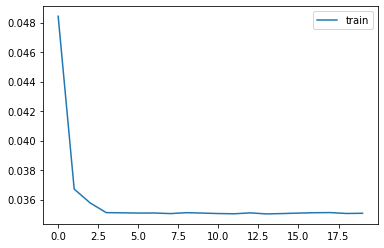

In [8]:
draw_history(history)

In [9]:
torch.save(model, 'AE64.pt')

In [10]:
embed = torch.FloatTensor(myDataset.data)
model.cpu()
with torch.no_grad():
    embed_64 = model.encode(embed)
    embed_64_np = embed_64.numpy()

print(embed_64.shape)
print(embed_64_np.shape)

np.save('../data/embed_64.npy', embed_64_np)

torch.Size([127036, 64])
(127036, 64)
